# LSTM Migraine Prediction

This notebook demonstrates migraine prediction using an LSTM model, following a similar structure to the Random Forest notebook.

## 1. Import Required Libraries
Import libraries for data handling, model building, and visualization.

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## 2. Prepare the Dataset
Load and inspect the dataset to be used for LSTM modeling.

In [3]:
from prediction.data_processing import merge_migraine_and_weather_data, process_combined_data

# Merge and process data
merge_migraine_and_weather_data()
data = process_combined_data()

data.drop(columns=['Notes'], inplace=True, errors='ignore')  # Drop 'Notes' column if it exists

data.head()

,Date,Time,Pain Level,Medication,Dosage,Triggers,Location,Latitude_x,Longitude_x,Timezone,...,Physical Activity_0.0,Physical Activity_1.0,tdiff,tavg_lag1,tavg_lag2,humid.*tavg,pres_change_lag1,pres_change_lag2,Pain_Level_Log,Pain_Level_Binary
0,2023-01-01,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,2.8,NaN,NaN,1147.928,NaN,NaN,0.0,0
1,2023-01-02,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,7.2,14.2,NaN,878.712,NaN,NaN,0.0,0
2,2023-01-03,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,4.4,11.4,14.2,1116.160,6.4,NaN,0.0,0
3,2023-01-04,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,3.8,12.8,11.4,1364.220,2.5,6.4,0.0,0
4,2023-01-05,0,0.0,NaN,NaN,NaN,"Carlsbad, California, USA",33.1581,-117.3506,America/Los_Angeles,...,False,False,6.1,15.9,12.8,1192.464,1.0,2.5,0.0,0


## 3. Preprocess Data for LSTM
Normalize the data, create sequences, and reshape for LSTM input.

In [16]:
# Select only non-zero pain level cases for regression
non_zero_data = data[data['Pain Level'] > 0].reset_index(drop=True)

# Drop columns with any NaN values (except the target column)
non_zero_data = non_zero_data.dropna(axis=1)

# Select features and target
feature_cols = non_zero_data.drop(columns=[
    'Date', 'date', 'Medication', 'Dosage', 'Triggers', 'Notes', 'Location', 'Timezone',
    'Pain Level', 'Pain_Level_Binary', 'Pain_Level_Log',
    'Longitude', 'Latitude', 'Time',
    'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y',
], errors='ignore').columns

# Make sure Pain_Level_Log is present and has no NaN
non_zero_data = non_zero_data.dropna(subset=['Pain_Level_Log'])

features = non_zero_data[feature_cols].values
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target = non_zero_data['Pain Level'].values

# Create LSTM sequences
def create_sequences(features, target, seq_len=7):
    X, y = [], []
    for i in range(len(features) - seq_len):
        X.append(features[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 7
X, y = create_sequences(features_scaled, target, SEQ_LEN)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"LSTM input shape: {X_train.shape}")

print("Any NaN left in features?", non_zero_data[feature_cols].isnull().any().any())
print("Any NaN left in target?", non_zero_data['Pain_Level_Log'].isnull().any())

LSTM input shape: (268, 7, 38)
Any NaN left in features? False
Any NaN left in target? False


## 4. Build the LSTM Model
Define and compile the LSTM model architecture using Keras.

In [11]:
from tensorflow.keras.metrics import MeanAbsoluteError

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])
model.summary()

/Users/Aresh/Desktop/Projects/Migraine Navigator/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,481 (111.25 KB)

 Trainable params: 28,481 (111.25 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the LSTM Model
Train the LSTM model on the prepared data and monitor training progress.

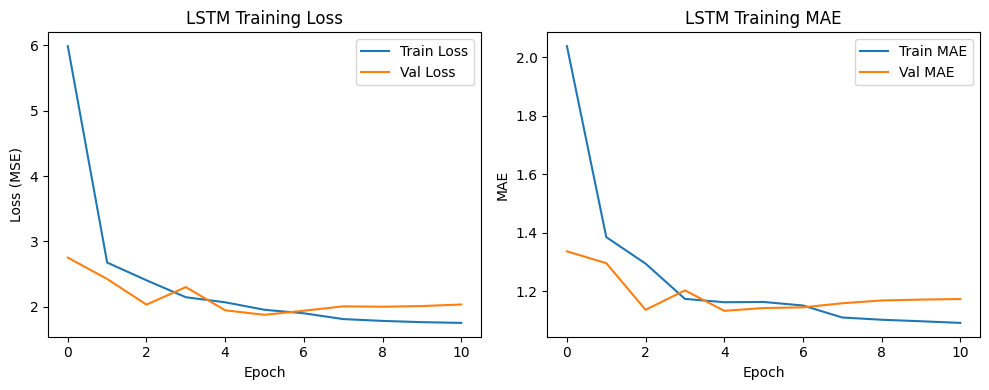

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Plot training history: loss and MAE
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('LSTM Training MAE')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluate Model Performance
Evaluate the trained LSTM model using regression metrics and visualize the results.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Regression Model R^2 score: 0.17205550913703382
Mean Absolute Error (MAE): 1.2230867449917011
Mean Squared Error (MSE): 2.246184446864476
Root Mean Squared Error (RMSE): 1.4987276092954571


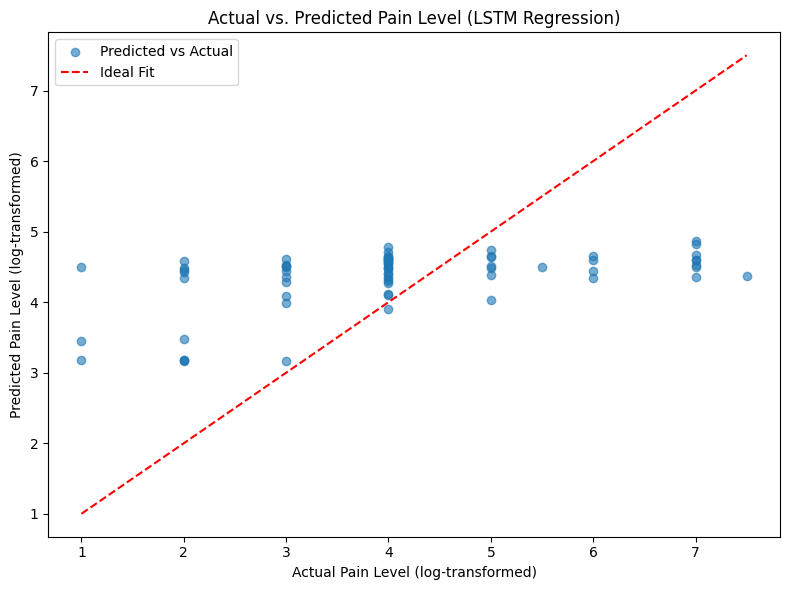

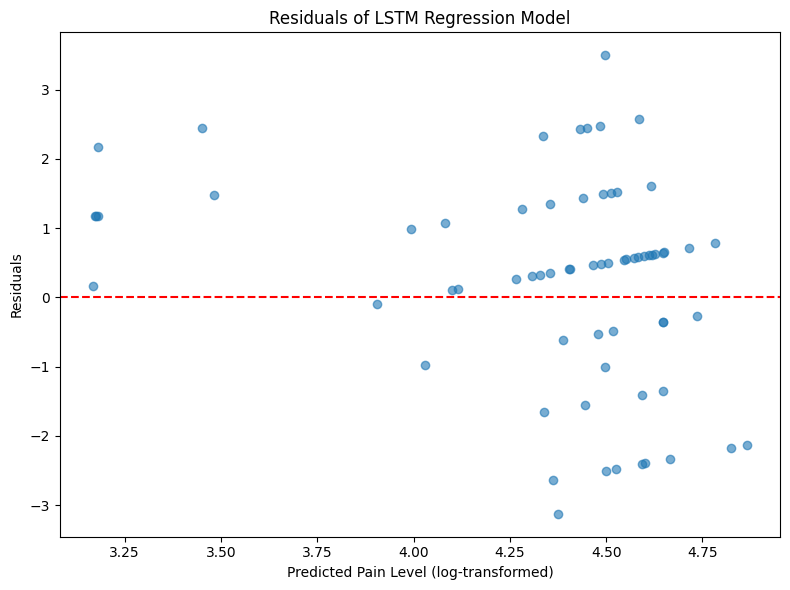

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"LSTM Regression Model R^2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Pain Level (log-transformed)')
plt.ylabel('Predicted Pain Level (log-transformed)')
plt.title('Actual vs. Predicted Pain Level (LSTM Regression)')
plt.legend()
plt.tight_layout()

# Residual Plot
plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_pred - y_test, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Pain Level (log-transformed)')
plt.ylabel('Residuals')
plt.title('Residuals of LSTM Regression Model')
plt.tight_layout()

## 7. Make Predictions with the LSTM Model

Use the trained LSTM model to make predictions on new/unseen data and visualize the results. This section demonstrates how to use the model for inference and interpret the outputs.

In [ ]:
# Example: Predict on a new sample (using the last sequence from the test set)
new_X = X_test[-1:]
new_y_true = y_test[-1]
new_y_pred = model.predict(new_X).flatten()[0]

print(f"True pain level (log-transformed): {new_y_true}")
print(f"Predicted pain level (log-transformed): {new_y_pred}")

# If you want to inverse the log transform to get the original scale:
# true_original = np.expm1(new_y_true)
# pred_original = np.expm1(new_y_pred)
# print(f"True pain level (original scale): {true_original}")
# print(f"Predicted pain level (original scale): {pred_original}")

# Visualize prediction vs. actual for a batch of test samples
plt.figure(figsize=(10,5))
plt.plot(y_test[:50], label='Actual', marker='o')
plt.plot(model.predict(X_test[:50]).flatten(), label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Pain Level (log-transformed)')
plt.title('LSTM Model Predictions vs. Actuals (First 50 Test Samples)')
plt.legend()
plt.tight_layout()
plt.show()